<a href="https://colab.research.google.com/github/zia207/r-colab/blob/main/NoteBook/Advance_Regression/02-02-02-regularized-glm-logistic-r.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![alt text](http://drive.google.com/uc?export=view&id=1bLQ3nhDbZrCCqy_WCxxckOne2lgVvn3l)

# 2. Regularized Logistic Regression (Gaussian)





## Overview

Regularized logistic regression, also known as penalized logistic regression, is an improved version of traditional logistic regression that employs regularization techniques to prevent overfitting and enhance model generalization. In logistic regression, the aim is to model the probability of a binary outcome based on one or more predictor variables. However, traditional logistic regression models may encounter high variance and poor generalization performance when dealing with datasets with many predictors or multicollinearity among predictors.

Regularization addresses these issues by adding a penalty term to the logistic regression objective function, penalizing the regression coefficients' magnitudes. This penalty encourages the model to shrink the coefficients towards zero or enforce sparsity, effectively reducing the complexity of the model and preventing overfitting. As a result, regularized logistic regression models can achieve better generalization performance and are less prone to overfitting than traditional logistic regression models.There are two types of regularization commonly used in logistic regression: `L1 regularization (LASOO)` and `L2 regularization (Ridge)`. `Elastic Net` regularization combines both L1 and L2 regularization and balances feature selection and coefficient shrinkage.

In ridge regression, the penalty term shrinks the coefficients, contributing the most to the error. This results in a reduced magnitude of these coefficients, decreasing the impact of features that contribute to increasing the error.

On the other hand, LASSO regression employs a different approach. Instead of shrinking the coefficients, it sets them exactly to zero! This unique property of LASSO model makes it an effective feature selector that identifies the most important coefficients with the lowest `p-values`, eliminating the features that have little impact on the model's predictive power.

Penalized logistic regression extends traditional logistic regression by adding a penalty term to the log-likelihood function. This penalty discourages large coefficients and helps prevent overfitting.

The **logit link function** in `glm()` models the log-odds:

$$ \text{logit}(P) = \ln\left(\frac{P}{1-P}\right) = \beta_0 + \beta_1 X_1 + \dots + \beta_p X_p $$,

where:

- $P = P(Y = 1 \mid \mathbf{X}) = \frac{1}{1 + e^{-(\beta_0 + \beta_1 X_1 + \dots + \beta_p X_p)}} $ is the probability of success.

- $\beta_0$: Intercept term.

- $\beta_j$: Coefficients for predictors $X_j$.

The **log-likelihood** function for logistic regression is:

$$ \ell(\boldsymbol{\beta}) = \sum_{i=1}^n \left[ Y_i \ln(\hat{P}_i) + (1 - Y_i) \ln(1 - \hat{P}_i) \right] $$,

where $\hat{P}_i = P(Y_i = 1 \mid \mathbf{X}_i)$.


To perform penalized logistic regression, a penalty term is added to the negative log-likelihood to shrink coefficients $\beta_j$.

The **penalized negative log-likelihood** is:

$$ \text{Penalized Loss} = -\ell(\boldsymbol{\beta}) + \lambda \cdot P(\boldsymbol{\beta}) $$

where:

- $P(\boldsymbol{\beta})$: Penalty function based on the coefficients.

- $\lambda$: Regularization strength, controlling the trade-off between goodness of fit and penalty.

***L1 Regularization (Lasso)***:
   
   $$ P(\boldsymbol{\beta}) = \sum_{j=1}^p |\beta_j|$$
   
   Encourages sparsity (some coefficients shrink to zero). Suitable for feature selection.

***L2 Regularization (Ridge)***:
   
   *** P(\boldsymbol{\beta}) = \sum_{j=1}^p \beta_j^2 ***

   Shrinks coefficients but keeps all predictors. Helps handle multicollinearity.

***Elastic Net*** (Combination of L1 and L2):

   $$ P(\boldsymbol{\beta}) = \alpha \sum_{j=1}^p |\beta_j| + (1 - \alpha) \sum_{j=1}^p \beta_j^2 $$

   where $0 \leq \alpha \leq 1$ balances L1 and L2 penalties.


Penalized logistic regression maximizes the penalized log-likelihood:

$$ \hat{\boldsymbol{\beta}} = \arg\max_{\boldsymbol{\beta}} \left( \ell(\boldsymbol{\beta}) - \lambda \cdot P(\boldsymbol{\beta}) \right) $$

This optimization is performed numerically. In R, packages like `glmnet` handle this process efficiently.



### Install rpy2

In [1]:
!pip uninstall rpy2 -y
!pip install rpy2==3.5.1
%load_ext rpy2.ipython

Found existing installation: rpy2 3.4.2
Uninstalling rpy2-3.4.2:
  Successfully uninstalled rpy2-3.4.2
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 201.7/201.7 kB 5.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for rpy2: filename=rpy2-3.5.1-cp311-cp311-linux_x86_64.whl size=314972 sha256=9348ea7bdcb3c2e5a8fafed7cb05cee51a9c7dec023e83931ff02a92150263c3
  Stored in directory: /root/.cache/pip/wheels/e9/55/d1/47be85a5f3f1e1f4d1e91cb5e3a4dcb40dd72147f184c5a5ef
Successfully built rpy2


### Mount Google Drive

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Regularized GLM Regression Model from Scratch

To perform regularized regression (Ridge, Lasso, and Elastic Net) on synthetic data in R without using any libraries, we need to manually implement each regularization method in the GLM framework. Here’s how to proceed:

1.  **Generate synthetic data** with one continuous response variable and four predictors.
2.  **Implement the objective functions** for Ridge, Lasso, and Elastic Net.
3.  **Optimize the objective functions** manually to fit the models.
4.  **Summarize and compare performance** of each model.
5.  **Cross-validation** to evaluate model performance.

### Generate Synthetic Data

Let's create synthetic data with one continuous response variable ( y ) and four predictors ( x_1, x_2, x_3, x_4 ).

In [3]:
%%R
# Set seed for reproducibility
set.seed(42)

# Generate synthetic data
n <- 100  # Number of observations
p <- 4    # Number of predictors

# Predictor matrix
X <- matrix(rnorm(n * p), nrow = n, ncol = p)

# Coefficients (true values for generating y)
beta_true <- c(3, -2, 0.5, 1.5)

# Generate response with some noise
y <- X %*% beta_true + rnorm(n)

### Define Objective Functions

For Ridge, Lasso, and Elastic Net, we define separate objective functions that add the corresponding regularization term to the residual sum of squares.

1.  **Ridge** (L2 regularization):

  $$  \mathcal{L}_{\text{ridge}}(\beta) = \sum_{i=1}^n (y_i - X_i \beta)^2 + \lambda \sum_{j=1}^p \beta_j^2 $$

2.  **Lasso** (L1 regularization):

  $$  \mathcal{L}_{\text{lasso}}(\beta) = \sum_{i=1}^n (y_i - X_i \beta)^2 + \lambda \sum_{j=1}^p |\beta_j  $$

3.  **Elastic Net** (combination of L1 and L2 regularization):

   $$  \mathcal{L}_{\text{elastic net}}(\beta) = \sum_{i=1}^n (y_i - X_i \beta)^2 + \lambda \left( \alpha \sum_{j=1}^p |\beta_j| + (1 - \alpha) \sum_{j=1}^p \beta_j^2 \right) $$



We’ll use gradient descent for optimization. Since Lasso (L1) and Elastic Net involve absolute values, we implement sub-gradient descent to handle them. The `ridge_regression()`, `lasso_regression()`, and `elastic_net()` functions will fit the models using the synthetic data. Gradient descent iteratively updates the coefficients to minimize the objective function by moving in the direction of the negative gradient. The learning rate (`lr`) controls the step size, and the maximum number of iterations (`max_iter`) determines when to stop. The `lambda` parameter controls the strength of regularization, and `alpha` is the mixing parameter for Elastic Net.

In [4]:
%%R
# Define gradient descent function for each type of regularization

# Ridge regression function
ridge_regression <- function(X, y, lambda, lr = 0.001, max_iter = 1000) {
  beta <- rep(0, ncol(X))
  for (iter in 1:max_iter) {
    gradient <- -2 * t(X) %*% (y - X %*% beta) / nrow(X) + 2 * lambda * beta
    beta <- beta - lr * gradient
  }
  return(beta)
}

# Lasso regression function
lasso_regression <- function(X, y, lambda, lr = 0.001, max_iter = 1000) {
  beta <- rep(0, ncol(X))
  for (iter in 1:max_iter) {
    gradient <- -2 * t(X) %*% (y - X %*% beta) / nrow(X)
    beta <- beta - lr * (gradient + lambda * sign(beta))
  }
  return(beta)
}

# Elastic Net function
elastic_net <- function(X, y, lambda, alpha, lr = 0.001, max_iter = 1000) {
  beta <- rep(0, ncol(X))
  for (iter in 1:max_iter) {
    gradient <- -2 * t(X) %*% (y - X %*% beta) / nrow(X)
    penalty <- alpha * lambda * sign(beta) + (1 - alpha) * lambda * beta
    beta <- beta - lr * (gradient + penalty)
  }
  return(beta)
}



### Fit the Models


In [5]:
%%R
# Set lambda and alpha values
lambda <- 0.1
alpha <- 0.5  # for Elastic Net

# Fit models
beta_ridge <- ridge_regression(X, y, lambda)
beta_lasso <- lasso_regression(X, y, lambda)
beta_elastic_net <- elastic_net(X, y, lambda, alpha)

# Combine coefficients into a data frame
coef_summary <- data.frame(
  Predictor = paste0("X", 1:4),
  Ridge = round(beta_ridge, 3),
  Lasso = round(beta_lasso, 3),
  Elastic_Net = round(beta_elastic_net, 3),
  True = beta_true
)

print(coef_summary)

  Predictor  Ridge  Lasso Elastic_Net True
1        X1  2.520  2.646       2.625  3.0
2        X2 -1.544 -1.611      -1.606 -2.0
3        X3  0.290  0.277       0.292  0.5
4        X4  1.290  1.334       1.336  1.5


### Evaluate Model Performance

To evaluate the models, calculate the Mean Squared Error (MSE) between the true response and predicted values.

In [6]:
%%R
# Function to calculate MSE
mse <- function(y, y_pred) {
  mean((y - y_pred)^2)
}

# Predicted values for each model
y_pred_ridge <- X %*% beta_ridge
y_pred_lasso <- X %*% beta_lasso
y_pred_elastic_net <- X %*% beta_elastic_net

# Calculate MSE for each model
mse_ridge <- mse(y, y_pred_ridge)
mse_lasso <- mse(y, y_pred_lasso)
mse_elastic_net <- mse(y, y_pred_elastic_net)

# Print MSE results
mse_results <- data.frame(
  Model = c("Ridge", "Lasso", "Elastic Net"),
  MSE = c(mse_ridge, mse_lasso, mse_elastic_net)
)

print(mse_results)

        Model      MSE
1       Ridge 1.760001
2       Lasso 1.554133
3 Elastic Net 1.570162


The outputs from `coef_summary` and `mse_results` give:

1.  **Coefficient Summary**: Shows the estimated coefficients for each predictor under Ridge, Lasso, and Elastic Net, along with the true values.
2.  **MSE Comparison**: Provides the MSE for each model, indicating how well each regularization approach fits the data. Generally:
    -   **Ridge** tends to shrink coefficients smoothly, useful for multicollinear predictors.
    -   **Lasso** can zero out coefficients, aiding in feature selection.
    -   **Elastic Net** balances between Lasso and Ridge, combining sparsity with smooth shrinkage.

These comparisons highlight how each method performs under different conditions and the effect of regularization on coefficient estimates.

### Cross-validation

We'll use $k$-fold cross-validation to evaluate model performance. Each fold will act as validation data once, while the remaining $k−1$ folds will act as training data. After training each model, we’ll calculate the MSE on the validation set and average these MSEs across all folds.

In [7]:
%%R
# Cross-validation function
cross_validation <- function(X, y, k = 5, lambda = 0.1, alpha = 0.5) {
  n <- nrow(X)
  indices <- sample(1:n)  # Randomize indices
  fold_size <- floor(n / k)

  # Initialize MSE storage
  mse_ridge <- mse_lasso <- mse_elastic_net <- numeric(k)

  # Loop through each fold
  for (i in 1:k) {
    # Split data into training and validation sets
    val_indices <- indices[((i - 1) * fold_size + 1):(i * fold_size)]
    train_indices <- setdiff(1:n, val_indices)

    X_train <- X[train_indices, ]
    y_train <- y[train_indices]
    X_val <- X[val_indices, ]
    y_val <- y[val_indices]

    # Fit each model
    beta_ridge <- ridge_regression(X_train, y_train, lambda)
    beta_lasso <- lasso_regression(X_train, y_train, lambda)
    beta_elastic_net <- elastic_net(X_train, y_train, lambda, alpha)

    # Predict on validation set and calculate MSE
    y_pred_ridge <- X_val %*% beta_ridge
    y_pred_lasso <- X_val %*% beta_lasso
    y_pred_elastic_net <- X_val %*% beta_elastic_net

    mse_ridge[i] <- mean((y_val - y_pred_ridge)^2)
    mse_lasso[i] <- mean((y_val - y_pred_lasso)^2)
    mse_elastic_net[i] <- mean((y_val - y_pred_elastic_net)^2)
  }

  # Return average MSE for each model
  return(data.frame(
    Model = c("Ridge", "Lasso", "Elastic Net"),
    MSE = c(mean(mse_ridge), mean(mse_lasso), mean(mse_elastic_net))
  ))
}

# Set parameters
lambda <- 0.1
alpha <- 0.5
k <- 5  # Number of folds

# Perform cross-validation
cv_results <- cross_validation(X, y, k, lambda, alpha)
print(cv_results)

        Model      MSE
1       Ridge 2.193662
2       Lasso 1.969980
3 Elastic Net 1.981856


The output `cv_results` will contain the average MSE across all folds for each model (Ridge, Lasso, Elastic Net). Comparing these values allows us to determine which regularization method performs best with this synthetic data.

## Regularized GLM Regression Model in R

To fit a Regularized Generalized Linear Model (GLM) with a Gaussian distribution (equivalent to linear regression) in R, we will use {glmnet} package. It is a highly versatile R package that can be utilized to fit Generalized Linear Models with regularization. It specializes in Lasso (L1) and Ridge (L2) regularization techniques, making it an ideal tool for dealing with high-dimensional data where the number of predictors exceeds the number of observations or when multicollinearity poses a challenge.


This package offers efficient algorithms for fitting penalized regression models, including the elastic net - a combination of Lasso and Ridge regression. Additionally, {glmnet} provides functions for cross-validation to identify the best regularization parameter and for extracting fitted model coefficients. "glmnet" is widely used in fields such as machine learning, statistics, and data science. It is an excellent choice for feature selection, prediction, and variable importance assessment tasks.

When working with {glmnet}, users can utilize various arguments to adjust the fitting process to their needs. This flexibility allows for a more tailored approach to the analysis and can lead to more accurate results. To help with this customization, we have outlined some of the most commonly used arguments below. However, for a more comprehensive understanding of the {glmnet} package and its capabilities, we recommend referring to the official documentation by typing `?glmnet`.

``` r
 glmnet(x, y, alpha = 1, lambda = NULL)
```

-   `x`: matrix of predictor variables

-   `y`: the response or outcome variable, which is a binary variable.

-   `alpha` is for the elastic net mixing parameter α, with range $α∈[0,1].α=1$ is lasso regression (default) and $α=0$ is ridge regression.

-   `nlambda` is the number of $λ$ values in the sequence (default is 100).

-   `lambda` can be provided if the user wants to specify the lambda sequence, but typical usage is for the program to construct the lambda sequence on its own. When automatically generated, the $λ$ sequence is determined by `lambda.max` and `lambda.min.ratio`. The latter is the ratio of smallest value of the generated $λ$ sequence (say `lambda.min`) to `lambda.max`. The program generates `nlambda` values linear on the log scale from `lambda.max` down to `lambda.min`. `lambda.max` is not user-specified but is computed from the input $x$ and $y$: it is the smallest value for `lambda` such that all the coefficients are zero. For `alpha = 0` (ridge) `lambda.max` would be $∞$: in this case we pick a value corresponding to a small value for `alpha` close to zero.)

-   `standardize` is a logical flag for `x` variable standardization prior to fitting the model sequence. The coefficients are always returned on the original scale. Default is `standardize = TRUE`.

**K-fold cross-validation** can be performed using the `cv.glmnet` function. In addition to all the glmnet parameters, `cv.glmnet` has its special parameters including `nfolds` (the number of folds), (user-supplied folds), and `type.measure` (the loss used for cross-validation): \`” or “mse” for squared loss, and

-   `mae` uses mean absolute error.

-   `alpha` is for the elastic net mixing parameter `α`, with range $α∈[0,1].α=1$ is lasso regression (default) and $α=0$ is ridge regression.

-   “1”: for lasso regression

-   “0”: for ridge regression

-   a value between 0 and 1 (say 0.3) for elastic net regression.

Here’s a guide on how to fit these models using synthetic data and evaluating the performance.

### Install Rrequired R Packages

In [13]:
%%R
packages <- c('tidyverse',
     'plyr',
		 'ggpmisc',
		 'rstatix',
		 'ggeffects',
		 'patchwork',
		 'Metrics',
		 'ggpmisc',
		 'glmnet',
		 'ROCR',
		 'pROC'
	  	)


In [ ]:
%%R
# Install missing packages
new.packages <- packages[!(pacakges %in% installed.packages(lib='drive/My Drive/R/')[,"Package"])]
if(length(new.packages)) install.packages(new.packages, lib='drive/My Drive/R/')

In [10]:
%%R
# set library path
.libPaths('drive/My Drive/R')
# Verify installation
cat("Installed packages:\n")
print(sapply(packages, requireNamespace, quietly = TRUE))

Installed packages:


  method                  from   
  heightDetails.titleGrob ggplot2
  widthDetails.titleGrob  ggplot2



tidyverse      plyr   ggpmisc   rstatix ggeffects patchwork   metrica   Metrics 
     TRUE      TRUE      TRUE      TRUE      TRUE      TRUE     FALSE      TRUE 
  ggpmisc    glmnet      ROCR      pROC 
     TRUE      TRUE      TRUE      TRUE 


### Load R Packages

In [14]:
%%R
# set library path
.libPaths('drive/My Drive/R')
# Load packages with suppressed messages
invisible(lapply(packages, function(pkg) {
  suppressPackageStartupMessages(library(pkg, character.only = TRUE))
}))
# Check loaded packages
cat("Successfully loaded packages:\n")
print(search()[grepl("package:", search())])# Check loaded packageswer)
library(glmnet)

Successfully loaded packages:
 [1] "package:pROC"      "package:ROCR"      "package:glmnet"   
 [4] "package:Matrix"    "package:Metrics"   "package:patchwork"
 [7] "package:ggeffects" "package:rstatix"   "package:ggpmisc"  
[10] "package:ggpp"      "package:plyr"      "package:lubridate"
[13] "package:forcats"   "package:stringr"   "package:dplyr"    
[16] "package:purrr"     "package:readr"     "package:tidyr"    
[19] "package:tibble"    "package:ggplot2"   "package:tidyverse"
[22] "package:tools"     "package:stats"     "package:graphics" 
[25] "package:grDevices" "package:utils"     "package:datasets" 
[28] "package:methods"   "package:base"     


### Data

Our goal is to develop a regularized logistic model to predict probability of paddy soil arsenic contamination (contaminated and non-contaminated) using selected irrigation water and soil properties. We have available data of 263 paired groundwater and paddy soil samples from arsenic contaminated areas in Tala Upazilla, Satkhira district, Bangladesh. This data was utilized in a publication titled "Factors Affecting Paddy Soil Arsenic Concentration in Bangladesh: Prediction and Uncertainty of Geostatistical Risk Mapping" which can be accessed via the this [URL](https://doi.org/10.1016/j.scitotenv.2011.10.008).

Full data set is available for download from my [Dropbox](https://www.dropbox.com/scl/fo/2rh6r68i9cxmgortvbw8q/h?rlkey=bvntt66n9mcywprmdki08ch3r&dl=0) or from my [Github](https://github.com/zia207/r-colab/tree/main/Data/Regression_analysis) accounts.


We will use `read_csv()` function of **readr** package to import data as a **tidy** data.


In [15]:
%%R
# load data from Github
# Load data
mf<-read_csv("https://github.com/zia207/r-colab/raw/main/Data/Regression_analysis/bd_soil_arsenic.csv")

Rows: 263 Columns: 29
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (1): Land_type
dbl (28): ID, Longitude, Latitude, WAs, WP, WFe, WEc, WpH, WMg, WNa, WCa, WK...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


#### Create a binary response variable

The `binary class` typically refers to a classification problem where there are only two possible classes or outcomes. As we see `SAs` is a continuous variable, but we need to convert it into binary class (contaminated and non-contaminated) based on our published paper. The paper suggests that we use the probability of exceeding the upper baseline soil arsenic concentration (14.8 mg/kg) to define soil samples as either As contaminated (`Yes`) or non-contaminated (`No`).

Here we will convert `Soil As (SAs)` into two classes- `Yes = Contaminated`and `No = noncontaminated` and create a new binary response variables (`Class_As`) with two levels:

Yes = `SAs` \> 14.8 mg As/kg

No = `SAs` \< 14.8 mg As/kg

In [16]:
%%R
mf$Class_As<- cut(mf$SAs,
                   breaks=c(-Inf, 14.8, Inf),
                   labels=c("0", "1"))
mf$Class_As<-as.factor(mf$Class_As)

#### Data Preparation

Data preparation is an essential step in the data analysis process. It involves cleaning, transforming, and organizing data to make it suitable for analysis. In this step, we will perform the following tasks:

In [17]:
%%R
df <- mf |>
  # select variables
  dplyr::select (WAs,  WFe,
                SAoFe, SOC,
                Year_Irrigation, Distance_STW,
                Land_type, Class_As) |>
   # convert to factor
   dplyr::mutate_at(vars(Land_type), funs(factor))  |>
   dplyr::mutate_at(vars(Class_As), funs(factor))  |>
   # normalize the all numerical features
   #dplyr::mutate_at(1:6,  funs((.-min(.))/max(.-min(.)))) |>
   glimpse()

Rows: 263
Columns: 8
$ WAs             <dbl> 0.059, 0.059, 0.079, 0.122, 0.072, 0.042, 0.075, 0.064…
$ WFe             <dbl> 3.44, 4.93, 9.70, 8.58, 4.78, 6.95, 7.81, 8.14, 8.99, …
$ SAoFe           <dbl> 2500, 2670, 2160, 2500, 2060, 2500, 2520, 2140, 2150, …
$ SOC             <dbl> 1.66, 1.26, 1.36, 1.61, 1.26, 1.74, 1.71, 1.69, 1.41, …
$ Year_Irrigation <dbl> 14, 20, 10, 8, 10, 9, 8, 10, 8, 2, 20, 4, 15, 10, 5, 4…
$ Distance_STW    <dbl> 5, 6, 5, 8, 5, 5, 10, 8, 10, 8, 5, 5, 9, 5, 10, 10, 12…
$ Land_type       <fct> MHL, MHL, MHL, MHL, MHL, MHL, MHL, MHL, MHL, MHL, MHL,…
$ Class_As        <fct> 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, …


### Split data into training and test

Split the data into training and test sets. We will use 70% of the data for training and 30% for testing. The `ddply()` function from the `plyr` package is used to split the data by the `Land_type` and `Class_As` variables.

In [18]:
%%R
seeds = 11076
tr_prop = 0.70
# training data (70% data)
train= plyr::ddply(df,.(Land_type, Class_As),
                 function(., seed) { set.seed(seed); .[sample(1:nrow(.), trunc(nrow(.) * tr_prop)), ] }, seed = 101)
test = plyr::ddply(df, .(Land_type, Class_As),
            function(., seed) { set.seed(seed); .[-sample(1:nrow(.), trunc(nrow(.) * tr_prop)), ] }, seed = 101)

### Create x and y

You need to create two objects:

-   `y` for storing the outcome variable
-   `x` for holding the predictor variables. This should be created using the function model.matrix() allowing to automatically transform any qualitative variables (if any) into dummy variables, which is important because `glmnet()` can only take numerical, quantitative inputs. After creating the model matrix, we remove the intercept component at index = 1.


In [19]:
%%R
# Predictor variables
x.train <- model.matrix(Class_As~., train)[,-1]
# Outcome variable
y.train <-train$Class_As

`model.matrix()` when you get "error in evaluating the argument 'x' in selecting a method for function 'as.matrix'". For some reason glmnet prefers `data.matrix()` to `as.matrix()`

### Ridge Regression

Ridge regression is a type of linear regression that uses L2 regularization to shrink the regression coefficients towards zero. This helps to prevent overfitting and improve the model's generalization performance. The `glmnet` package in R provides efficient functions for fitting ridge regression models.


#### Cross-validation for the best lambda

Now we can apply `cv.glmnet()` function for cross-validation to choose the best lambda (regularization parameter). For example, suppose we designate $α$=0 for ridge regression and specify `nlambda` as 200. This implies that the model fit will be calculated solely for 200 $λ$ values.

In [20]:
%%R
# cross validation
ridge.cv <- cv.glmnet(x= x.train,
                       y= y.train,
                       type.measure="deviance",
                       nfold = 5,
                       alpha=0,
                       family="binomial",
                       nlambda=200,
                       standardize = TRUE)

Printing the resulting object gives some basic information on the cross-validation performed:

In [21]:
%%R
print(ridge.cv)


Call:  cv.glmnet(x = x.train, y = y.train, type.measure = "deviance",      nfolds = 5, alpha = 0, family = "binomial", nlambda = 200,      standardize = TRUE) 

Measure: Binomial Deviance 

     Lambda Index Measure      SE Nonzero
min 0.02984   192  0.8800 0.04925       7
1se 0.15079   157  0.9266 0.03374       7


We can plot `ridge.cv` object to see how each tested lambda value performed:

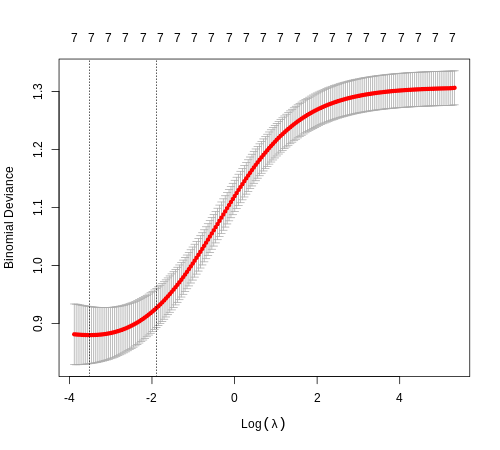

In [23]:
%%R -w 500 -h 450 -u px
plot(ridge.cv)

Generally, the purpose of regularization is to balance accuracy and simplicity. This means, a model with the smallest number of predictors that also gives a good accuracy. To this end, the function `cv.glmnet()` finds also the value of lambda that gives the simplest model but also lies within one standard error of the optimal value of lambda. This value is called `lambda.1se`.

#### Fit ridge regression

Now Fit the final model with the best "lambda":

In [24]:
%%R
# fit ridge regression
ridge.fit <-  glmnet(x= x.train,
                       y= y.train,
                       alpha=0,
                       lambda = ridge.cv$lambda.1se,
                       family = "binomial",
                       nlambda=200,
                       standardize = TRUE)

In [ ]:
# Display regression coefficients
coef(ridge.fit )

#### Prediction on test data

Prediction at this stage is done on the test data. We will use the `predict()` function to make predictions on the test data. The `type="response"` argument is used to get the predicted probabilities. We will also create a new column `Class_Prob_50` to store the predicted class based on a threshold of 0.5.

In [25]:
%%R
# Make predictions on the test data
x.test <- model.matrix(Class_As~., test)[,-1]
# Outcome variable
y.test <-train$Class_As

# Prediction
ridge.pred<-as.data.frame(test$Class_As)
ridge.pred$Class_Prob<-ridge.fit  |>
      predict(newx = x.test, type="response")
ridge.pred$Class_Prob_50<-ifelse(ridge.pred$Class_Prob > 0.5,"1","0")
ridge.pred <- ridge.pred |>
              dplyr::select("test$Class_As", "Class_Prob_50") |>
              dplyr::rename(Obs_Class = "test$Class_As") |>
              dplyr::rename(Pred_Class = "Class_Prob_50")
glimpse(ridge.pred)

# ordering the levels
ridge.pred$Obs_Class  <- ordered(ridge.pred$Obs_Class, levels = c("1", "0"))
ridge.pred $Pred_Class <- ordered(ridge.pred$Pred_Class  , levels = c("1", "0"))

Rows: 80
Columns: 2
$ Obs_Class  <fct> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,…
$ Pred_Class <chr[,1]> "1", "0", "0", "0", "0", "0", "1", "1", "0", "1", "0", …


#### Model performance

Following function can be used to evaluate the model performance using accuracy, error rate, and confusion matrix:

In [26]:
%%R
evaluate_classification <- function(observed, predicted) {
  # Convert inputs to factors if not already
  observed <- as.factor(observed)
  predicted <- as.factor(predicted)

  # Create a confusion matrix
  confusion_matrix <- table(Predicted = predicted, Actual = observed)

  # Extract values from confusion matrix
  TP <- confusion_matrix["1", "1"] # True Positives
  TN <- confusion_matrix["0", "0"] # True Negatives
  FP <- confusion_matrix["1", "0"] # False Positives
  FN <- confusion_matrix["0", "1"] # False Negatives

  # Handle cases where confusion matrix values may not exist
  TP <- ifelse(is.na(TP), 0, TP)
  TN <- ifelse(is.na(TN), 0, TN)
  FP <- ifelse(is.na(FP), 0, FP)
  FN <- ifelse(is.na(FN), 0, FN)

  # Compute metrics
  accuracy <- (TP + TN) / (TP + TN + FP + FN)
  precision <- ifelse((TP + FP) > 0, TP / (TP + FP), NA)
  recall <- ifelse((TP + FN) > 0, TP / (TP + FN), NA)  # Also called sensitivity
  specificity <- ifelse((TN + FP) > 0, TN / (TN + FP), NA)
  f1_score <- ifelse(!is.na(precision) & !is.na(recall) & (precision + recall) > 0,
                     2 * (precision * recall) / (precision + recall), NA)

  # Return results as a list
  metrics <- list(
    ConfusionMatrix = confusion_matrix,
    Accuracy = accuracy,
    Precision = precision,
    Recall = recall,
    Specificity = specificity,
    F1_Score = f1_score
  )

  return(metrics)
}


In [27]:
%%R
evaluate_classification(ridge.pred$Obs_Class, ridge.pred$Pred_Class)

$ConfusionMatrix
         Actual
Predicted  1  0
        1 45 13
        0  7 15

$Accuracy
[1] 0.75

$Precision
[1] 0.7758621

$Recall
[1] 0.8653846

$Specificity
[1] 0.5357143

$F1_Score
[1] 0.8181818



#### ROC Curve

ROC curve is a graphical representation of the true positive rate (sensitivity) against the false positive rate (1-specificity). It shows the trade-off between sensitivity and specificity for different threshold values. The area under the ROC curve (AUC) is a measure of the model's performance. A model with an AUC of 1 is perfect, while a model with an AUC of 0.5 is no better than random guessing.

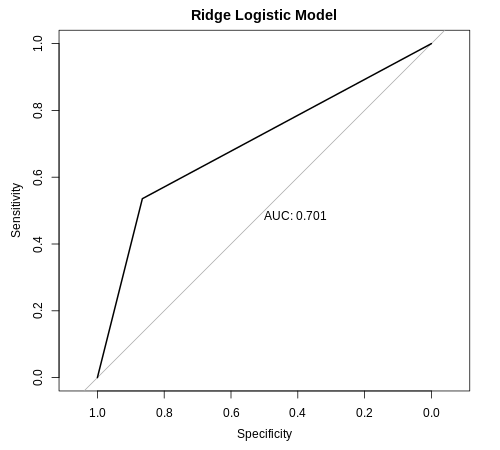

In [28]:
%%R -w 500 -h 450 -u px
res.roc <- pROC::roc(ridge.pred$Obs_Class, ridge.pred$Pred_Class)
plot.roc(res.roc,
         print.auc = TRUE,
         main= "Ridge Logistic Model")

### LASSO regression

LASSO regression is a type of linear regression that uses L1 regularization to shrink the regression coefficients towards zero. This helps to prevent overfitting and improve the model's generalization performance. The `glmnet` package in R provides efficient functions for fitting LASSO regression models.

#### Cross Validation of the best Lasso regression

We can set up our model very similarly to our ridge function. We simply need to change the `alpha`argument to 1 and do K-fold cross-validation:

In [29]:
%%R
# cross validation
lasso.cv <- cv.glmnet(x= x.train,
                       y= y.train,
                       type.measure="mse",
                       nfold = 5,
                       alpha=1,
                       family="binomial",
                       nlambda=200,
                       standardize = TRUE)

In [31]:
%%R
print(lasso.cv)


Call:  cv.glmnet(x = x.train, y = y.train, type.measure = "mse", nfolds = 5,      alpha = 1, family = "binomial", nlambda = 200, standardize = TRUE) 

Measure: Mean-Squared Error 

     Lambda Index Measure      SE Nonzero
min 0.00508    81  0.2783 0.03473       7
1se 0.05906    28  0.3117 0.01924       6


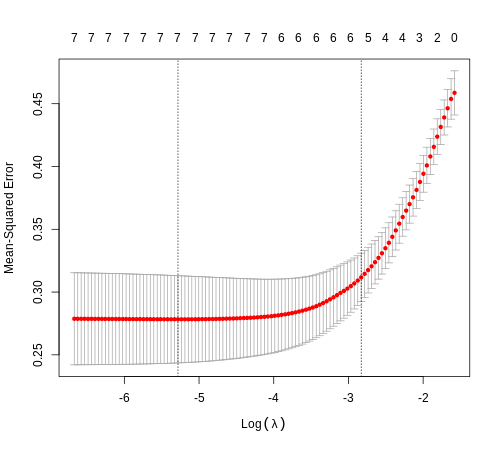

In [33]:
%%R -w 500 -h 450 -u px
plot(lasso.cv)

In [35]:
%%R
# Choose lambda with standard error of the minimum
lasso.cv$lambda.1se

[1] 0.05906412


#### Fit a lasso regression

Now Fit the final model with the best "lambda":

In [36]:
%%R
# fit lasso regression
lasso.fit <-  glmnet(x= x.train,
                       y= y.train,
                       alpha=1,
                       lambda = lasso.cv$lambda.1se,
                       family="binomial",
                       nlambda=200,
                       standardize = TRUE)

In [37]:
%%R
print(lasso.fit)


Call:  glmnet(x = x.train, y = y.train, family = "binomial", alpha = 1,      nlambda = 200, lambda = lasso.cv$lambda.1se, standardize = TRUE) 

  Df  %Dev  Lambda
1  6 30.83 0.05906


Finally we will extract the coefficients for the selected $λ$ using `coef()` function:

In [38]:
%%R
coef(lasso.fit)

8 x 1 sparse Matrix of class "dgCMatrix"
                          s0
(Intercept)     -2.115990618
WAs              4.066476107
WFe              0.125839634
SAoFe            .          
SOC              0.111318058
Year_Irrigation  0.146725917
Distance_STW    -0.002809843
Land_typeMHL     0.870813521


#### Prediction test data

In [39]:
%%R
# Make predictions on the test data
x.test <- model.matrix(Class_As~., test)[,-1]
# Outcome variable
y.test <-train$Class_As

# Prediction
lasso.pred<-as.data.frame(test$Class_As)
lasso.pred$Class_Prob<-lasso.fit  |>
      predict(newx = x.test, type="response")
lasso.pred$Class_Prob_50<-ifelse(lasso.pred$Class_Prob > 0.5,"1","0")
lasso.pred <- lasso.pred |>
              dplyr::select("test$Class_As", "Class_Prob_50") |>
              dplyr::rename(Obs_Class = "test$Class_As") |>
              dplyr::rename(Pred_Class = "Class_Prob_50")
glimpse(lasso.pred)

# ordering the levels
lasso.pred$Obs_Class  <- ordered(lasso.pred$Obs_Class, levels = c("1", "0"))
lasso.pred $Pred_Class <- ordered(lasso.pred$Pred_Class  , levels = c("1", "0"))

Rows: 80
Columns: 2
$ Obs_Class  <fct> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,…
$ Pred_Class <chr[,1]> "1", "0", "0", "0", "0", "0", "1", "0", "0", "1", "0", …


#### Model performance

In [40]:
%%R
evaluate_classification(lasso.pred$Obs_Class, lasso.pred$Pred_Class)

$ConfusionMatrix
         Actual
Predicted  1  0
        1 46 12
        0  6 16

$Accuracy
[1] 0.775

$Precision
[1] 0.7931034

$Recall
[1] 0.8846154

$Specificity
[1] 0.5714286

$F1_Score
[1] 0.8363636



#### ROC Curve

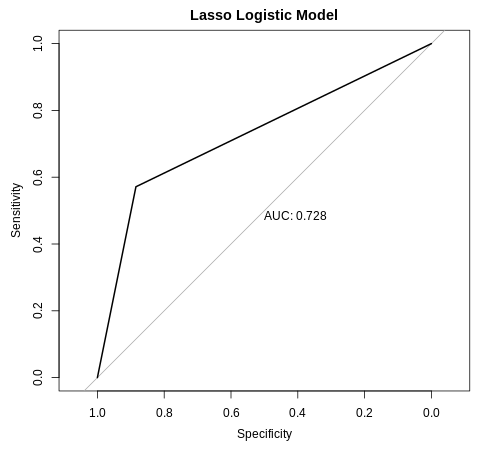

In [41]:
%%R -w 500 -h 450 -u px
# Compute roc
library(pROC)
res.roc <- pROC::roc(lasso.pred$Obs_Class, lasso.pred$Pred_Class)
plot.roc(res.roc,
         print.auc = TRUE,
         main= "Lasso Logistic Model")

### Elastic Net Regression

Elastic Net regression is a combination of L1 (LASSO) and L2 (Ridge) regularization. It provides a balance between feature selection and coefficient shrinkage. The `glmnet` package in R provides efficient functions for fitting Elastic Net regression models.

#### Cross Validation of the best Elastic Net regression

We can set up our model very similarly to our ridge function. We simply need to change the `alpha`argument to a value between 0 and 1 and do K-fold cross-validation:

In [43]:
%%R
# Define hyperparameter grid
alphas <- seq(0, 1, by = 0.1)                   # Grid for alpha
lambda_seq <- 10^seq(3, -3, length = 100)       # Grid for lambda

# To store results
results <- data.frame(alpha = numeric(), lambda = numeric(), error = numeric())

# Perform grid search
for (a in alphas) {
  # Fit glmnet model for each alpha
  cv_fit <- cv.glmnet(x.train, y.train, family = "binomial", alpha = a, lambda = lambda_seq, type.measure = "class")

  # Extract best lambda and error for the current alpha
  best_lambda <- cv_fit$lambda.min
  best_error <- min(cv_fit$cvm)  # Minimum cross-validation error

  # Store results
  results <- rbind(results, data.frame(alpha = a, lambda = best_lambda, error = best_error))
}

# Print results
print(results)


best_params <- results[which.min(results$error), ]
print(best_params)

# Refit the final model with optimal parameters
enet.fit <- glmnet(x.train, y.train, family = "binomial", alpha = best_params$alpha, lambda = best_params$lambda)

# View coefficients
print(coef(enet.fit))

   alpha     lambda     error
1    0.0 0.07564633 0.2021858
2    0.1 0.06579332 0.1803279
3    0.2 0.03274549 0.1857923
4    0.3 0.02848036 0.1803279
5    0.4 0.04328761 0.1803279
6    0.5 0.05722368 0.1912568
7    0.6 0.02848036 0.1857923
8    0.7 0.02477076 0.1803279
9    0.8 0.02848036 0.1803279
10   0.9 0.04328761 0.1803279
11   1.0 0.02848036 0.1857923
  alpha     lambda     error
2   0.1 0.06579332 0.1803279
8 x 1 sparse Matrix of class "dgCMatrix"
                           s0
(Intercept)     -3.255323e+00
WAs              6.046513e+00
WFe              1.964624e-01
SAoFe            5.624383e-06
SOC              6.730575e-01
Year_Irrigation  1.585023e-01
Distance_STW    -3.348883e-02
Land_typeMHL     8.921267e-01


#### Prediction test data

Prediction at this stage is done on the test data. We will use the `predict()` function to make predictions on the test data. The `type="response"` argument is used to get the predicted probabilities. We will also create a new column `Class_Prob_50` to store the predicted class based on a threshold of 0.5.

In [44]:
%%R
# Make predictions on the test data
x.test <- model.matrix(Class_As~., test)[,-1]
# Outcome variable
y.test <-train$Class_As

# Prediction
enet.pred<-as.data.frame(test$Class_As)
enet.pred$Class_Prob<-enet.fit  |>
      predict(newx = x.test, type="response")
enet.pred$Class_Prob_50<-ifelse(enet.pred$Class_Prob > 0.5,"1","0")
enet.pred <- enet.pred |>
              dplyr::select("test$Class_As", "Class_Prob_50") |>
              dplyr::rename(Obs_Class = "test$Class_As") |>
              dplyr::rename(Pred_Class = "Class_Prob_50")
glimpse(enet.pred)

# ordering the levels
enet.pred$Obs_Class  <- ordered(enet.pred$Obs_Class, levels = c("1", "0"))
enet.pred $Pred_Class <- ordered(enet.pred$Pred_Class  , levels = c("1", "0"))

Rows: 80
Columns: 2
$ Obs_Class  <fct> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,…
$ Pred_Class <chr[,1]> "1", "0", "0", "0", "0", "0", "1", "1", "0", "1", "0", …


#### Model performance

In [45]:
%%R
evaluate_classification (enet.pred$Obs_Class , enet.pred$Pred_Class)

$ConfusionMatrix
         Actual
Predicted  1  0
        1 44 12
        0  8 16

$Accuracy
[1] 0.75

$Precision
[1] 0.7857143

$Recall
[1] 0.8461538

$Specificity
[1] 0.5714286

$F1_Score
[1] 0.8148148



#### ROC Curve

ROC curve is a graphical representation of the true positive rate (sensitivity) against the false positive rate (1-specificity). It shows the trade-off between sensitivity and specificity for different threshold values. The area under the ROC curve (AUC) is a measure of the model's performance. A model with an AUC of 1 is perfect, while a model with an AUC of 0.5 is no better than random guessing.

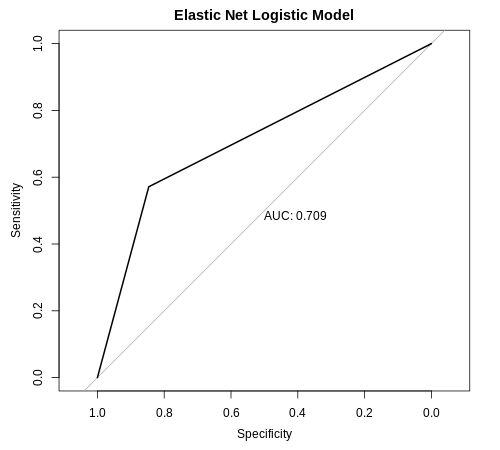

In [46]:
%%R -w 500 -h 450 -u px
# Compute roc
#library(pROC)
enet.roc <- pROC::roc(enet.pred$Obs_Class, enet.pred$Pred_Class)
plot.roc(enet.roc,
         print.auc = TRUE,
         main= "Elastic Net Logistic Model")

## Summary and Conclusion

In this tutorial, we explored regularized logistic regression, using the **glmnet** packags in R. This package ise useful for building robust classifiers for binary classification tasks with regularization. Here, we focused on `lasso` and `ridge` models, using `alpha = 1` and `alpha = 0`, respectively. For `elastic net` regression, you need to choose an alpha value somewhere between `0 and 1`. This can be parameter tuning using grid search with the **caret** or **h20** packages (please see Machine Learning chapter).

In [ ]:
## References

1.  [Ridge and Lasso in R](https://www.datacareer.ch/blog/ridge-and-lasso-in-r/)

2.  [Penalized Logistic Regression Essentials in R: Ridge, Lasso and Elastic Net](http://www.sthda.com/english/articles/36-classification-methods-essentials/149-penalized-logistic-regression-essentials-in-r-ridge-lasso-and-elastic-net/)